# General Attention Mechanism
Di era deep learning modern, attention mechanism telah menjadi salah satu terobosan terbesar dalam memproses data berurutan, khususnya dalam pemrosesan bahasa alami (NLP). Konsep dasarnya sederhana, namun revolusioner yaitu setiap elemen dalam suatu urutan dapat "memperhatikan" elemen lain, lalu menimbang informasi yang relevan untuk menghasilkan representasi yang lebih kaya. Mekanisme ini mengatasi keterbatasan pendekatan tradisional seperti RNN yang sulit menangkap dependensi jarak jauh.

Notebook ini dirancang untuk membawa pembaca memahami mekanisme tersebut secara intuitif. Mulai dari membentuk representasi Query (Q), Key (K), dan Value (V), hingga melihat langsung bagaimana bobot perhatian (attention weights) dihitung dan diterapkan. Visualisasi heatmap termasuk versi interaktif digunakan untuk menunjukkan bahwa perhatian tidak selalu statis. Sebelum pelatihan, distribusinya acak; setelah pelatihan, pola tersebut menjadi terarah dan bermakna.

Urgensinya jelas yaitu tanpa pemahaman mendalam terhadap attention, kita hanya akan menggunakan Transformer atau model sejenis seperti "black box" tanpa benar-benar mengerti bagaimana informasi berpindah dan diolah di dalamnya. Dengan menguasai mekanisme ini, kita tidak hanya mampu memahami model, tetapi juga mengadaptasinya untuk berbagai tantangan, mulai dari penerjemahan mesin, analisis sentimen, hingga pengolahan data non-teks seperti citra dan deret waktu. Kelebihan attention meliputi kemampuannya menangkap hubungan antar elemen tanpa batasan urutan, kemudahan paralelisasi komputasi, serta fleksibilitas untuk digunakan di berbagai domain.

# Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Membuat fungsi softmax
Mengubah angka menjadi probabilitas yang totalnya 1, sambil mencegah hasil perhitungan menjadi terlalu besar atau terlalu kecil sehingga komputer tetap bisa menghitungnya dengan akurat.

In [2]:
def softmax(x):
    """Softmax yang stabil secara numerik, baris-per-baris (axis=-1)."""
    x = np.asarray(x, dtype=np.float64)
    x_shift = x - np.max(x, axis=-1, keepdims=True)
    exp_x = np.exp(x_shift)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# Visualisasi Heatmap Attention
Menampilkan peta warna (heatmap) yang menggambarkan seberapa besar atensi (attention weights) setiap token query terhadap token key, sehingga hubungan antar kata dapat terlihat secara visual.

In [3]:
def heatmap_attention(weights, xlabels, ylabels, title):
    """Menampilkan heatmap attention menggunakan matplotlib (tanpa seaborn)."""
    fig = plt.figure(figsize=(6.5, 5.5))
    plt.imshow(weights, aspect='auto')
    plt.title(title)
    plt.xlabel('Key (K)')
    plt.ylabel('Query (Q)')
    plt.xticks(ticks=np.arange(len(xlabels)), labels=xlabels, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(ylabels)), labels=ylabels)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Representasi Token: One-Hot ➜ Proyeksi Q, K, V
* One-hot adalah cara paling sederhana untuk merepresentasikan kata/token dalam bentuk vektor.
* Meskipun tidak memuat makna semantik, ia memudahkan kita memahami proses awal Transformer karena setiap kata diwakili vektor yang berbeda secara tegas.
* Proyeksi Q, K, dan V adalah transformasi linier dari representasi tersebut untuk mempersiapkan perhitungan atensi.

## Definisi token dan one-hot
* Token adalah unit dasar teks (kata, sub-kata, atau karakter) yang menjadi input model.
* One-hot merepresentasikan setiap token sebagai vektor panjang n (jumlah token unik), dengan satu elemen bernilai 1 dan sisanya 0.
* Tujuannya adalah memastikan identitas setiap token terjaga sebelum diproyeksikan ke ruang vektor yang lebih bermakna.

In [4]:
tokens = ["A", "B", "C", "D"]
I = np.eye(len(tokens))  # matriks identitas -> one-hot untuk 4 token

In [5]:
print("Tokens:", tokens)
print("\nOne-hot (I):\n", I)

Tokens: ['A', 'B', 'C', 'D']

One-hot (I):
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


## Matriks bobot acak
* Bobot acak digunakan sebagai pengganti bobot hasil pelatihan untuk menyederhanakan simulasi.
* Matriks ini akan mengubah representasi one-hot menjadi vektor Q, K, dan V.
* Walaupun acak, ia memberi gambaran bagaimana bobot berperan sebagai “jembatan” antara representasi awal dan perhitungan atensi.

In [6]:
np.random.seed(42)
W_Q = np.random.randint(0, 3, size=(4, 4))  # 4x4 agar mudah ditelusuri
W_K = np.random.randint(0, 3, size=(4, 4))
W_V = np.random.randint(0, 3, size=(4, 4))

In [7]:
print("\nW_Q:\n", W_Q)
print("\nW_K:\n", W_K)
print("\nW_V:\n", W_V)


W_Q:
 [[2 0 2 2]
 [0 0 2 1]
 [2 2 2 2]
 [0 2 1 0]]

W_K:
 [[1 1 1 1]
 [0 0 1 1]
 [0 0 0 2]
 [2 2 1 2]]

W_V:
 [[1 1 2 1]
 [2 2 0 2]
 [0 2 2 0]
 [0 2 1 0]]


## Proyeksi Q, K, V
* Proyeksi adalah operasi perkalian matriks yang menghasilkan tiga vektor, yaitu Query (Q), Key (K), dan Value (V).
* Q merepresentasikan apa yang sedang dicari oleh suatu token
* K menyimpan apa yang dimiliki oleh token lain
* V memuat informasi yang akan dibagikan.

In [8]:
Q = I @ W_Q
K = I @ W_K
V = I @ W_V

In [9]:
print("\nQ = I @ W_Q:\n", Q)
print("\nK = I @ W_K:\n", K)
print("\nV = I @ W_V:\n", V)


Q = I @ W_Q:
 [[2. 0. 2. 2.]
 [0. 0. 2. 1.]
 [2. 2. 2. 2.]
 [0. 2. 1. 0.]]

K = I @ W_K:
 [[1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 2.]
 [2. 2. 1. 2.]]

V = I @ W_V:
 [[1. 1. 2. 1.]
 [2. 2. 0. 2.]
 [0. 2. 2. 0.]
 [0. 2. 1. 0.]]


# Scaled Dot-Product Attention
* Ini adalah mekanisme inti yang mengukur seberapa relevan token satu terhadap token lainnya.
* Ini mengandalkan kesamaan Q dengan K, lalu menggunakan bobot tersebut untuk menggabungkan nilai V.

## Skor kesamaan Q vs K
* Dihitung dengan dot product antara Q dan K.T.
* Semakin besar skor, semakin tinggi kesesuaian antara dua token.
* Ini merepresentasikan tingkat atensi yang harus diberikan.

In [10]:
scores = Q @ K.T

In [11]:
print("Scores (Q @ K.T):\n", scores)

Scores (Q @ K.T):
 [[ 6.  4.  4. 10.]
 [ 3.  3.  2.  4.]
 [ 8.  4.  4. 14.]
 [ 3.  1.  0.  5.]]


### Interpretasi
* Angka besar menunjukkan Query lebih mirip dengan Key tersebut, ini masih skor mentah sebelum skala dan softmax.
* Q(A) paling tinggi ke K(D) dengan nilai 10.
* Q(B) paling tinggi ke K(D) dengan nilai 4.
* Q(C) paling tinggi ke K(D) dengan nilai 14.
* Q(D) paling tinggi ke K(D) dengan nilai 5, dan bernilai 0 ke K(C) yang berarti hampir tidak terkait.
* Kolom D memiliki total skor tertinggi dibanding kolom lain sehingga kemungkinan besar akan mendominasi atensi setelah softmax.
* Ada potensi konsentrasi atensi (“attention collapse”) ke token D.
* Nilai 0 di baris Q(D) kolom K(C) akan tetap sangat kecil setelah softmax, sehingga D tidak akan banyak mengambil informasi dari C.

## Skala dengan \sqrt(d_k)
* Skor dibagi dengan akar dari dimensi K(sqrt(d_k)) untuk mencegah nilai terlalu besar yang dapat membuat softmax menjadi terlalu “tajam” dan tidak stabil secara numerik.

In [12]:
d_k = K.shape[1]
scaled_scores = scores / np.sqrt(d_k)

In [13]:
print("\nScaled Scores (scores / sqrt(d_k)):\n", scaled_scores)


Scaled Scores (scores / sqrt(d_k)):
 [[3.  2.  2.  5. ]
 [1.5 1.5 1.  2. ]
 [4.  2.  2.  7. ]
 [1.5 0.5 0.  2.5]]


## Softmax ➜ attention weights
* Softmax mengubah skor menjadi distribusi probabilitas sehingga bobot atensi antar token selalu berada di antara 0–1 dan berjumlah 1.
* Bobot ini menentukan porsi informasi yang diambil dari setiap token lain.

In [14]:
weights = softmax(scaled_scores)

In [15]:
print("\nAttention Weights (softmax):\n", weights)


Attention Weights (softmax):
 [[0.10959126 0.04031637 0.04031637 0.80977599]
 [0.23500371 0.23500371 0.14253696 0.38745562]
 [0.04682479 0.00633705 0.00633705 0.94050111]
 [0.23205671 0.08536889 0.05177885 0.63079554]]


### Interpretasi
* Nilai di setiap baris adalah probabilitas atensi untuk sebuah Query terhadap semua Key.
* Q(A) fokus 80,98% ke K(D), sisanya terbagi kecil ke K(A), K(B), dan K(C).
* Q(B) distribusi atensi lebih seimbang, namun tetap cenderung tinggi ke K(D) (38,75%).
* Q(C) sangat dominan ke K(D) (94,05%) sehingga hampir mengabaikan token lain.
* Q(D) mayoritas atensi ke K(D) (63,08%), sisanya ke K(A) dan K(B) secara moderat.
* Token D menjadi pusat atensi utama hampir semua Query.
* Distribusi ini menunjukkan pola “attention bias” yang terpusat ke satu token tertentu.

## Weighted sum atas V
* Bobot atensi digunakan untuk menggabungkan nilai V, menghasilkan vektor konteks akhir yang sudah “memperhatikan” hubungan antar token.

In [16]:
attention_output = weights @ V

In [17]:
print("\nAttention Output (weights @ V):\n", attention_output)


Attention Output (weights @ V):
 [[0.19022401 1.89040874 1.10959126 0.19022401]
 [0.70501114 1.76499629 1.14253696 0.70501114]
 [0.05949889 1.95317521 1.04682479 0.05949889]
 [0.4027945  1.76794329 1.19846667 0.4027945 ]]


### Interpretasi
* Setiap baris adalah representasi akhir per Query setelah menggabungkan baris-baris V sesuai bobot atensi.
* Pola nilai terbesar konsisten pada kolom ke-2 dan ke-3, menandakan dimensi Value tersebut paling “terambil” oleh mayoritas Query.
* Q(A) sangat dipengaruhi V dari token D, sehingga outputnya mendekati kombinasi yang didominasi V[D].
* Q(B) lebih campuran karena distribusi atensinya paling seimbang; kontribusi dari V[A], V[B], dan V[D] terlihat.
* Q(C) hampir seluruhnya mengikuti V[D] karena bobot ke K(D) ~94%; outputnya paling dekat dengan baris V[D].
* Q(D) tetap didominasi V[D] namun masih mengambil porsi dari V[A] dan V[B] sesuai bobotnya.
* Nilai kolom ke-1 dan ke-4 identik pada setiap baris, mengindikasikan kolom 1 dan 4 pada matriks V identik atau sangat mirip.
* Secara umum, output adalah kombinasi cembung (weighted sum) dari baris-baris V; dominasi atensi ke D membuat seluruh output condong ke informasi yang dibawa token D.

# Heatmap Attention Weights
* Visualisasi ini menunjukkan bobot atensi antara setiap Query dan Key.
* Warna lebih gelap/terang menandakan tingkat atensi yang berbeda, sehingga kita bisa melihat token mana yang paling memengaruhi token lainnya.

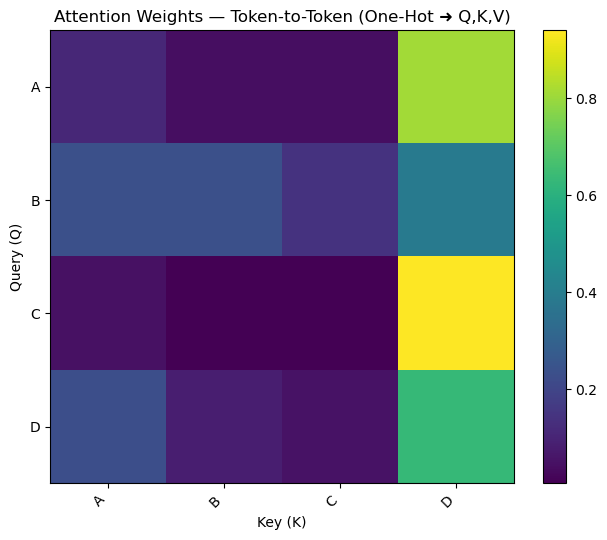

In [18]:
heatmap_attention(
    weights,
    xlabels=tokens,
    ylabels=tokens,
    title="Attention Weights — Token-to-Token (One-Hot ➜ Q,K,V)"
)

### Interpretasi
* Sumbu vertikal menunjukkan Query, sumbu horizontal menunjukkan Key.
* Warna lebih terang berarti bobot atensi lebih besar, warna gelap berarti lebih kecil.
* Q(A) kuat ke K(D) (hijau terang), atensi rendah ke token lainnya.
* Q(B) lebih seimbang dengan intensitas menengah ke semua Key, namun tetap cenderung ke K(D).
* Q(C) hampir seluruh atensi ke K(D) (kuning sangat terang), token lain hampir diabaikan.
* Q(D) dominan ke K(D) namun tetap memberi porsi ke K(A) dan K(B).
* Token D adalah pusat atensi utama hampir semua Query, yang selaras dengan interpretasi matriks attention weights sebelumnya.
* Pola ini menggambarkan “attention fokus tunggal” yang berpotensi mengabaikan informasi dari token selain D.

# Representasi Token: Embedding Acak ➜ Q, K, V
* Pendekatan ini menggunakan vektor embedding berdimensi tetap yang dihasilkan secara acak untuk setiap token, bukan one-hot.
* Hal ini mencerminkan cara model NLP modern merepresentasikan kata, di mana embedding dapat memuat informasi semantik dan hubungan antar kata.

## Embedding acak
* Kode `np.random.seed(7)` memastikan hasil embedding acak yang konsisten setiap kali dijalankan.
* Matriks embedding E dibuat dengan nilai acak, mewakili setiap token dalam dimensi numerik yang lebih kaya dibandingkan one-hot.

In [19]:
np.random.seed(7)
n_tokens = 6
d_embed = 4

tokens2 = ["The", "cat", "sat", "on", "the", "mat"]
E = np.random.rand(n_tokens, d_embed)  # embedding acak

In [20]:
print("Tokens:", tokens2)
print("\nEmbedding acak: \n", E)

Tokens: ['The', 'cat', 'sat', 'on', 'the', 'mat']

Embedding acak: 
 [[0.07630829 0.77991879 0.43840923 0.72346518]
 [0.97798951 0.53849587 0.50112046 0.07205113]
 [0.26843898 0.4998825  0.67923    0.80373904]
 [0.38094113 0.06593635 0.2881456  0.90959353]
 [0.21338535 0.45212396 0.93120602 0.02489923]
 [0.60054892 0.9501295  0.23030288 0.54848992]]


## Matriks bobot acak
* Tiga matriks bobot (W_Q, W_K, W_V) diinisialisasi secara acak.
* Setiap matriks bertugas memproyeksikan embedding awal ke ruang vektor yang berbeda untuk menghasilkan Query, Key, dan Value.

In [25]:
W_Q2 = np.random.randn(d_embed, d_embed)
W_K2 = np.random.randn(d_embed, d_embed)
W_V2 = np.random.randn(d_embed, d_embed)

In [26]:
print("\nW_Q2:\n", W_Q2)
print("\nW_K2:\n", W_K2)
print("\nW_V2:\n", W_V2)


W_Q2:
 [[-0.30019374 -1.17998209  1.49763912 -0.28263524]
 [ 0.10864837  1.43823952  1.50331852 -0.21273297]
 [ 0.33197422  0.73502658 -0.19285546 -1.77801285]
 [ 0.6547057   0.8943523   0.41550261 -0.92354466]]

W_K2:
 [[-0.19602731 -0.59076982 -0.29971124  1.29688519]
 [ 1.52957963  0.66941819  0.54874512  0.67662899]
 [-0.01224219 -0.07566346 -0.67364519 -0.05586745]
 [ 2.25994699  0.86903933 -0.34211702 -0.47192665]]

W_V2:
 [[-0.86448999  0.37437035  0.39154569 -1.44312166]
 [ 0.4863352  -0.56947227  1.42672116  0.15684398]
 [ 1.71773005 -0.45812679 -0.28798387  0.29980835]
 [ 1.0559483   0.56588249 -1.23352394  0.1829007 ]]


## Proyeksi Q, K, V
* Embedding E dikalikan dengan masing-masing matriks bobot untuk menghasilkan Q, K, dan V.
* Q digunakan untuk mencari informasi yang relevan.
* K berperan sebagai indeks atau penanda.
* V berisi informasi yang akan diambil.

In [27]:
Q2 = E @ W_Q2
K2 = E @ W_K2
V2 = E @ W_V2

In [28]:
print("\nQ2 = E @ W_Q2:\n", Q2)
print("\nK2 = E @ W_K2:\n", K2)
print("\nV2 = E @ W_V2:\n", V2)


Q2 = E @ W_Q2:
 [[-0.64386591 -0.91485619 -2.16466135 -1.63873334]
 [ 1.99683901 -0.80037147 -1.11768452  1.24189052]
 [-0.19382783 -0.5362756  -2.47010516 -0.40295602]
 [-0.57360185  0.33015813 -2.26593865  0.32880563]
 [ 1.2678089  -0.99744527 -1.00869586  0.38057559]
 [ 0.28428404 -1.08788422 -1.92083834 -1.07183332]]

K2 = E @ W_K2:
 [[ 0.00976995 -1.19884219  2.12905808  0.54475717]
 [-1.56165532  0.3915069   2.36293912  0.41585083]
 [-0.8468103  -1.34388471  2.55506267  1.2526051 ]
 [-0.65049734 -0.4516729   2.55981411  0.68835626]
 [-1.46095484 -1.46153055  1.03808042  1.68821487]
 [-0.17005334  0.00397833  2.7373555  -0.26533662]]

V2 = E @ W_V2:
 [[-1.55050142 -1.06905075 -0.99121105  0.89233676]
 [-0.88596908 -0.50229526 -0.31641628  1.11582524]
 [-1.24876899 -1.69152147 -1.10990674  0.82376447]
 [-0.51100848 -1.22942762 -1.17106292 -0.50459884]
 [-0.98012976 -1.51668718 -0.19357514  2.02985977]
 [-1.59772872 -0.29882683 -0.84716169  0.76321515]]


## Skor kesamaan Q vs K
* Menggunakan operasi dot product Q @ K.T, didapat skor yang mengukur kedekatan atau relevansi antara token.

In [29]:
scores2 = Q2 @ K2.T

In [30]:
print("Scores (Q @ K2.T):\n", scores2)

Scores (Q @ K2.T):
 [[-4.41092381 -5.14910749 -5.80883763 -5.83711421 -2.73587727 -5.38477973]
 [-0.7240584  -5.55630451 -1.91549247 -2.94363386 -0.81119266 -3.7317722 ]
 [-4.8374944  -5.91154104 -5.93119028 -6.23208169 -2.17748728 -6.62380936]
 [-5.04660732 -4.19251341 -5.33571416 -5.35004331 -1.44166179 -6.1910674 ]
 [-0.73208489 -4.59561147 -1.8337124  -2.69428963 -0.79902887 -3.08170312]
 [-3.36648632 -5.85441469 -5.02918991 -5.34835045 -2.62881974 -5.02629217]]


## Skala dengan sqrt(d_k)
* Skor dibagi dengan akar dari dimensi Key (sqrt(d_k)) untuk mencegah nilai terlalu besar yang dapat menyebabkan distribusi softmax terlalu tajam.

In [33]:
scaled_scores2 = scores2 / np.sqrt(K2.shape[1])

In [34]:
print("\nScaled Scores (scores / sqrt(d_k)):\n", scaled_scores2)


Scaled Scores (scores / sqrt(d_k)):
 [[-2.2054619  -2.57455375 -2.90441881 -2.91855711 -1.36793863 -2.69238987]
 [-0.3620292  -2.77815226 -0.95774624 -1.47181693 -0.40559633 -1.8658861 ]
 [-2.4187472  -2.95577052 -2.96559514 -3.11604085 -1.08874364 -3.31190468]
 [-2.52330366 -2.09625671 -2.66785708 -2.67502165 -0.7208309  -3.0955337 ]
 [-0.36604244 -2.29780574 -0.9168562  -1.34714482 -0.39951444 -1.54085156]
 [-1.68324316 -2.92720734 -2.51459495 -2.67417522 -1.31440987 -2.51314608]]


## Softmax ➜ attention weights
* Softmax mengubah skor tereskalasi menjadi probabilitas, menunjukkan seberapa besar atensi diberikan tiap token terhadap token lainnya.

In [35]:
weights2 = softmax(scaled2)

In [36]:
print("\nAttention Weights (softmax):\n", weights2)


Attention Weights (softmax):
 [[0.17845229 0.12337512 0.08870927 0.0874639  0.41233848 0.10966095]
 [0.31749028 0.02834141 0.17499024 0.10465398 0.30395513 0.07056895]
 [0.14595119 0.08530635 0.08447235 0.07267363 0.55184973 0.05974675]
 [0.09185895 0.14079448 0.07949554 0.07892802 0.55709015 0.05183286]
 [0.29653963 0.04296636 0.17094932 0.111172   0.28677814 0.09159455]
 [0.2514415  0.07247533 0.10949278 0.09334276 0.36359611 0.10965153]]


## Weighted sum atas V
* Bobot probabilitas digunakan untuk menggabungkan nilai (V) menjadi representasi akhir yang berfokus pada informasi terpenting.

In [37]:
out2 = weights2 @ V2

In [38]:
print("\nAttention Output (weights2 @ V):\n", out2)


Attention Output (weights2 @ V):
 [[-1.12082291 -1.16848757 -0.58952555  1.24653016]
 [-1.20004572 -1.26040597 -0.75906827  1.07712036]
 [-1.08084305 -1.28594931 -0.50796212  1.42411608]
 [-1.03560692 -1.26084751 -0.4680132   1.43510427]
 [-1.19556106 -1.22676372 -0.76056433  1.04930664]
 [-1.17006619 -1.18940366 -0.66627672  1.17007272]]


## Ringkasan

In [39]:
print("Embedding acak (E):\n", E)
print("\nAttention Weights (embedding acak):\n", weights2)
print("\nAttention Output (weights @ V:\n", out2)

Embedding acak (E):
 [[0.07630829 0.77991879 0.43840923 0.72346518]
 [0.97798951 0.53849587 0.50112046 0.07205113]
 [0.26843898 0.4998825  0.67923    0.80373904]
 [0.38094113 0.06593635 0.2881456  0.90959353]
 [0.21338535 0.45212396 0.93120602 0.02489923]
 [0.60054892 0.9501295  0.23030288 0.54848992]]

Attention Weights (embedding acak):
 [[0.17845229 0.12337512 0.08870927 0.0874639  0.41233848 0.10966095]
 [0.31749028 0.02834141 0.17499024 0.10465398 0.30395513 0.07056895]
 [0.14595119 0.08530635 0.08447235 0.07267363 0.55184973 0.05974675]
 [0.09185895 0.14079448 0.07949554 0.07892802 0.55709015 0.05183286]
 [0.29653963 0.04296636 0.17094932 0.111172   0.28677814 0.09159455]
 [0.2514415  0.07247533 0.10949278 0.09334276 0.36359611 0.10965153]]

Attention Output (weights @ V:
 [[-1.12082291 -1.16848757 -0.58952555  1.24653016]
 [-1.20004572 -1.26040597 -0.75906827  1.07712036]
 [-1.08084305 -1.28594931 -0.50796212  1.42411608]
 [-1.03560692 -1.26084751 -0.4680132   1.43510427]
 [-1.1

### Interpretasi
1. Karakteristik nilai
    - Nilai berkisar sekitar -1.28 hingga 1.43.
    - Dimensi ke-4 (kolom terakhir) umumnya bernilai positif dan cukup besar, sedangkan dimensi lain cenderung negatif.
    - Ada sedikit variasi antar token, tapi pola distribusinya relatif konsisten.
2. Dimensi dominan positif
   - Kolom ke-4 (1.24, 1.07, 1.42, dst.) memiliki nilai paling besar dan konsisten positif → kemungkinan attention “menarik” informasi yang sangat penting ke dimensi ini (bisa diasosiasikan dengan fitur semantik tertentu).
3. Dimensi negatif konsisten
    - Kolom ke-1, ke-2, dan ke-3 mayoritas negatif, menunjukkan bahwa setelah penggabungan nilai V, dimensi ini memberikan penekanan atau penurunan kontribusi fitur tertentu.
4. Interpretasi umum
   - Dimensi ke-4 memiliki nilai positif terbesar di semua token, menunjukkan fitur ini paling dominan setelah proses attention.
   - Dimensi ke-1, ke-2, dan ke-3 umumnya bernilai negatif, yang menandakan adanya penekanan atau pengurangan kontribusi fitur tertentu.
   - Perbedaan nilai antar token relatif kecil, mengindikasikan distribusi atensi model cenderung merata.
   - Representasi setiap token sudah mengandung informasi dari token lain sesuai bobot attention, sehingga lebih kontekstual.
   - Pola nilai yang konsisten menunjukkan model mengekstraksi fitur semantik tertentu yang sama pentingnya di seluruh token.

## Heatmap Attention Weights
* Visualisasi distribusi atensi antar token menggunakan peta warna, membantu memahami pola fokus model.

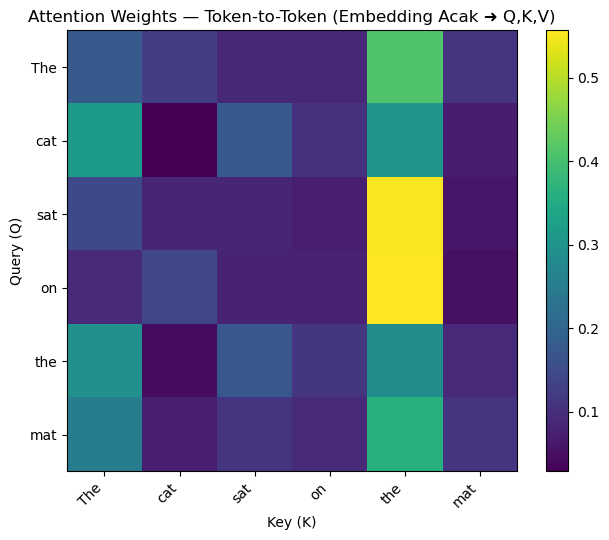

In [40]:
heatmap_attention(
    weights2,
    xlabels=tokens2,
    ylabels=tokens2,
    title="Attention Weights — Token-to-Token (Embedding Acak ➜ Q,K,V)"
)

### Interpretasi
- Token "the" (huruf kecil) mendapatkan atensi (attention) tertinggi dari beberapa token lain, terlihat dari warna kuning cerah di kolomnya.
- Token "sat" dan "on" memberikan atensi terbesar ke token "the", yang menunjukkan dominasi hubungan ke kata tersebut.
- Token "cat", "the", dan "mat" memiliki distribusi atensi yang lebih merata ke beberapa token lain, tanpa satu fokus tunggal yang ekstrem.
- Token pertama "The" (huruf besar) cenderung memberi atensi sedang ke token "the" (huruf kecil), menunjukkan adanya perbedaan meski kata sama tapi berbeda posisi/kapitalisasi.
- Nilai atensi terendah umumnya ada pada diagonal selain token dominan, menandakan token tersebut kurang memberi atensi pada dirinya sendiri.

## Heatmap interaktif
* Versi interaktif memudahkan eksplorasi nilai atensi secara langsung, memungkinkan pengamatan detail pada pasangan token tertentu.

In [41]:
try:
    from ipywidgets import interact, IntSlider

    def recompute(seed=0):
        np.random.seed(seed)
        W_Qi = np.random.randint(0, 3, size=(4, 4))
        W_Ki = np.random.randint(0, 3, size=(4, 4))
        W_Vi = np.random.randint(0, 3, size=(4, 4))

        Q_i = I @ W_Qi
        K_i = I @ W_Ki
        V_i = I @ W_Vi

        scores_i = Q_i @ K_i.T
        scaled_i = scores_i / np.sqrt(K_i.shape[1])
        weights_i = softmax(scaled_i)

        heatmap_attention(
            weights_i,
            xlabels=tokens,
            ylabels=tokens,
            title=f"Attention Weights — seed={seed}"
        )

    interact(recompute, seed=IntSlider(min=0, max=50, step=1, value=0));
except Exception as e:
    print("Interaksi ipywidgets tidak tersedia di lingkungan ini:", e)

interactive(children=(IntSlider(value=0, description='seed', max=50), Output()), _dom_classes=('widget-interac…

### Interpretasi
- Pola blok warna berubah → menunjukkan token mana yang saling memperhatikan berubah sepenuhnya.\
Ini membuktikan bahwa attention di awal sepenuhnya ditentukan oleh bobot awal dan belum punya makna semantik.
- Kadang ada token dominan → warna cerah di satu kolom menandakan banyak token "memperhatikan" token itu, tapi itu murni hasil angka acak, bukan karena makna.
- Distribusi bisa rata atau terpusat → beberapa seed menghasilkan pola atensi yang hampir rata (warna seragam), sedangkan yang lain lebih terpusat (warna terang di area tertentu).
- Hubungan antar token belum konsisten → misalnya pada seed tertentu, kata "cat" mungkin banyak diperhatikan, tapi di seed lain sama sekali tidak.
- Artinya belum ada knowledge yang stabil.

# Kesimpulan
Attention mechanism adalah lebih dari sekadar operasi matriks, karena inti dari kemampuan model modern untuk memahami konteks. Eksperimen seed yang menghasilkan pola perhatian berbeda memperlihatkan bahwa sebelum pelatihan, fokus model hanyalah hasil kebetulan dari inisialisasi parameter. Namun, melalui pelatihan, mekanisme ini berkembang menjadi sistem yang mampu memilih informasi penting dan mengabaikan yang tidak relevan.

Dari sudut pandang praktis, pemahaman ini menjadi bekal berharga. Kita tidak lagi melihat attention sebagai proses misterius, tetapi sebagai alat yang dapat kita kendalikan dan optimalkan. Keunggulan utamanya, menangkap hubungan jarak jauh, bekerja efisien secara paralel, dan fleksibel di berbagai jenis data, menjadikannya pilar utama banyak model canggih saat ini. Kesimpulannya, memahami attention mechanism berarti membuka pintu untuk menguasai arsitektur modern seperti Transformer dan turunannya.

# Thank You